## Introduction to End-To-End Automatic Speech Recognition

We'll be using the [AN4 dataset from CMU](http://www.speech.cs.cmu.edu/databases/an4/)(with processing using `sox`)

## What is ASR ?

**Automatic Speech Recognition**, refers to the problem of getting a program to automatically transcribe spoken language (speech-to-text). Our goal is usually to have a model that minimizes the **Word Error Rate (WER)** metric when transcribing speech input. 

Traditional speech recognition takes a generative approach, modeling the full pipeline of how speech sounds are produced in order to evaluate a speech sample. We would start from a **language model** that encapsulates the most likely orderings of words that are generated (e.g an n-gram model), to a **pronunciation model** for each word in that ordering (e.g. a pronunciation table), to an **acoustic model** that translates those pronunciations to audio waveforms (e.g. a gaussian mixture model).

Then, if we receive some spoken input, our goal would be to find the most likely sequence of text that would result in the given audio  according to our generative pipeline of models. Overall, with traditional speech recognition, we try to model `Pr(audio|transcript)*Pr(transcript)`, and take the argmax of this over the possible transcripts.

We can see the appeal of **End-To-End ASR architectures**: discriminative models that simply take the audio input and give a textual output, andf in which all the components are trained together towards the same goal. The model's encoder would be akin to an acoustic model for extracting speech features, which can then be directly piped to a decoder which output texts. If desired, we could integrate a language model that would improve our predictions.

|

## End-to-End ASR

we want to directly learn `Pr(transcript|audio)` in order to predict the transcripts from the original audio. Since we are dealing with sequential info RNNs are obvious choice. But now we have a pressing problem to deal with: since our input sequence (number of audio timesteps) is not the same length as our desired output (transcript length), how do we match each timestep from the audio  data to the correct output characters ?

Earlier speech recognition approaches relied on **temporally-aligned data**, in which each segment of time in an audio file was matched up to a corresponding speech sound such as phoneme or word. However, if we would like to have the flexibility to predict letter-by-letter to prevent OOV (out of vocabulary) issues, then each time step in the data would have to be labeled with the letter sound that the speaker is making at that point in the audio file. With that information, it seems like we should simply be able to try to predict the correct letter for each time step and then collapse the repeated letters (`LLAAAAPPTOOOOP` -> `LAPTOP`) . It turns out that this idea has some problems: not only does alignment make the dataset incredibly labor-intensive to label, but also, what do we do  with words like 'books' that contain consecutive repeated letters ? 

Modern end-to-end approaches get around this using methods that don't require manual alignment at all, so that the input-output pairs are really just the raw audio and the 
transcript - no extra data or labelling required. 2 popular approaches to do this: Connectionist Temporal Classification (CTC) and sequence-to-sequence models with attention

## CTC

In normal speech recognition prediction output, we would expect to have characters such as the letters from A through Z, numbers 0 through 9, spaces ("_") and so on. CTC introduces a new intermediate output token called the **blank token** ("-") that is useful getting around the alignment problem. 

With CTC, we still predict one token per time segment of speech, but we use the blank token to figure out where we can and can't collapse the predictions. The appearance of a blank token helps separate repeating letters that should be collapsed. For instance, with an audio snippet segment into `T=11` time steps, we could get predictions that look like `BOO-OOO--KK`, which would then collapse to `BO-O-K` and then we would remove the blank tokens to get our final output `BOOK`.

Now, we can predict one output token per time step, then collapse and clean to get sensible output without any fear of ambiguity from repeating letters! A simple way of getting predictions like this would be to apply a bidirectionnal RNN to the audio input, apply softmax over each time step's output, and then take the token with the highest probability. The method of taking always the best token at each time step is called **greedy decoding, or max decoding**


To calculate the loss for backprop, we would like to know the log probability of the model producing the correct transcript, `log(Pr(transcript|audio))`. We can get the log probability of a single intermediate output sequence (e.g. `BOO-OOO--KK`) by summing over the log probabilities we get from each token's softmax value, but note that the resulting sum is different from the log probability of the transcript itself (`BOOK`). This is because there are multiple possible output sequences of the same length that can be collapsed to the same transcript and so we need to **marginalize over every valid sequence of length `T` that collapse to the transcript**

Therefore, to get our transcript's log proba given our audio input, we must sum the log probabilities if every sequence of length `T` that collapses to the transcript. In practice, we can use a dynamic programming approach to calculate this, accumulating our log probabilities over different "paths" through the softmax outputs at each time step.

## Sequence-to-Sequence with Attention

One problem with CTC is that predictions at different time steps are conditionally independent, which is an issue because the words in a continuous utterance tend to be related to each other in some sensible way. With this conditional independence assumption, we can't learn a language model that can represent such dependencies, though we can add a language model on top of the CTC output to mitigate this to some degree

A popular alternative is to use sequence-to-sequence model with attention. A typical seq2seq model for ASR consists of some sort of **bidirectional RNN encoder** that consume the audio sequence timestep-by-timestep, and where the output are then passed to an **attention-based decoder**. Each prediction from the decoder is based on attending to some parts of the entire encoded input, as well as the previously outputted tokens.

The outputs of the decoder can be anything from word pieces to phonemes to letters, and since predictions are not directly tied to time steps of the input, we can just continue producing tokens one-by-one until an end token is given (or we reach a specified max output length). This way, we do not need to deal with audio alignment, and our predicted transcript is just the sequence of the outputs given by our decoder.


## Taking a Look at Our Data (AN4)

The AN4 dataset, also known as the Alphanumeric dataset, was collected and published by Carnegie Mellon University. It consists of recordings of people spelling out addresses, names, telephone numbers, etc., one letter or number at a time, as well as their corresponding transcripts. We choose to use AN4 for this tutorial because it is relatively small, with 948 training and 130 test utterances, and so it trains quickly.

Before we get started, let's download and prepare the dataset. The utterances are available as `.sph` files, so we will need to convert them to `.wav` for later processing. If you are not using Google Colab, please make sure you have [Sox](http://sox.sourceforge.net/) installed for this step--see the "Downloads" section of the linked Sox homepage. (If you are using Google Colab, Sox should have already been installed in the setup cell at the beginning.)

In [2]:
import os 
data_dir = 'data/'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [3]:
import glob
import os 
import subprocess
import tarfile 
import wget

# Download the dataset
print("*****")
if not os.path.exists(data_dir + 'an4_sphere.tar.gz'):
    an4_url = 'https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url,data_dir)
    print(f"Dataset downloaded at {an4_path}" )
else:
    print("Tarfile already exists")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)
    print('Converting .sph to .wav..')
    sph_list = glob.glob(data_dir + 'an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + ".wav"
        cmd = ['sox', sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion. \n*****")

*****
Tarfile already exists
Finished conversion. 
*****


In [6]:
import librosa
import IPython.display as ipd

# Load and listen the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

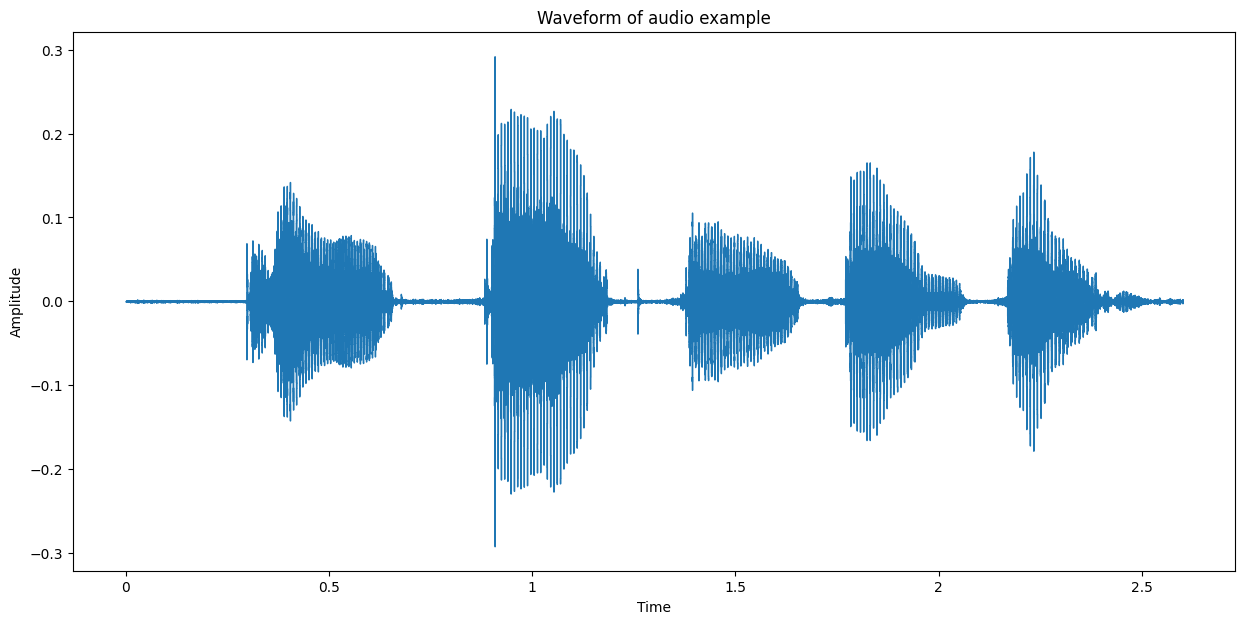

In [4]:
%matplotlib inline

import librosa.display
import matplotlib.pyplot as plt

# Plot our audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of audio example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio)

We can see the activity in the waveform that corresponds to each letter in the audio, each spoken letter has a different "shape" 

## Spectrogram and Mel Spectrograms

since audio information is more useful in the context of frequencies of sound over time , we can get a better representation than this raw sequence of 57,330 values. We can apply a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) on our audio signal to get something more useful: a **spectrogram**, which is a representation of the energy levels (i.e amplitude or "loudness") of each frequency (i.e pitch) of the signal over the duration of the file. A spectrogram (which can be viewed as a heat map) is a good way of seeing how the *strengths of various frequencies in the audio vary over time*, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Text(0.5, 1.0, 'Audio Spectrogram')

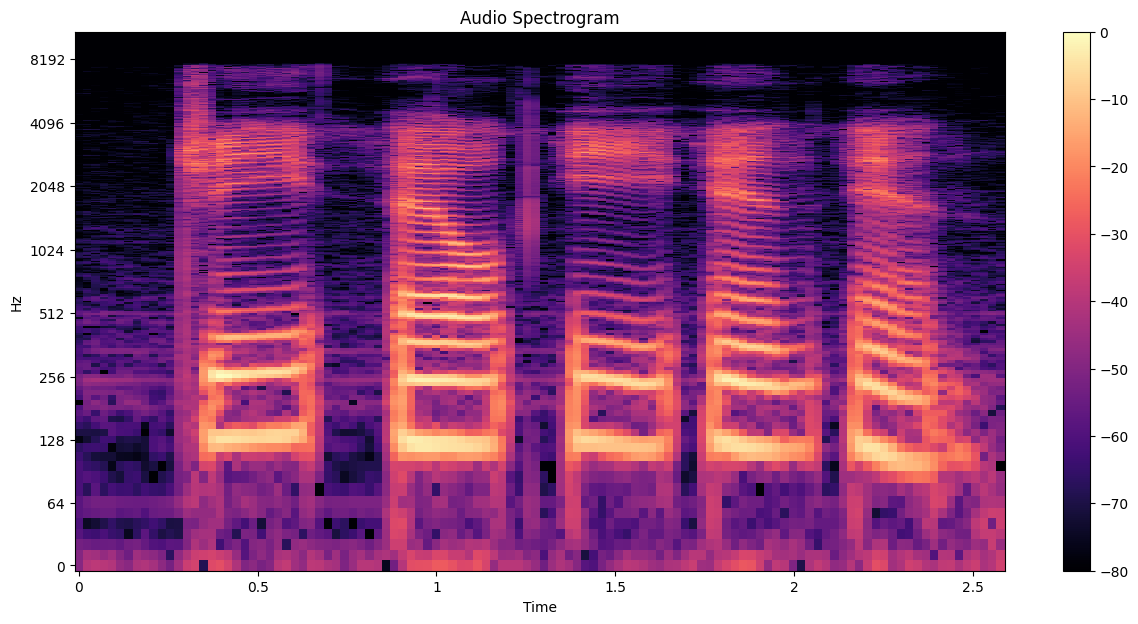

In [5]:
%matplotlib inline
import numpy as np

# Get spectrogram using Librosa's stft
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)

# use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram')

Using  the **Mel spectrogram** instead of normal spectrogram. This is simply a change in the frequency scale that we use from linear (or logarithmic) to the mel scale, which is "a perceptual scale of pitches judged by listeners to be equal in distance from one another"

It's a transformation of the frequencies to be more aligned to what humans perceive; a change of +1000Hz from 2000Hz -> 3000Hz sounds like a larger difference to us than 9000Hz -> 10_000Hz does, so the mel scale normalizes this such that equal distances sound like equal differences to the human ear. Intuitively, we use the mel spectrogram because in this case we are processing and transcribing human speech, such that transforming the scale to better match what we hear is a useful procedure.

Text(0.5, 1.0, 'Mel Spectrogram')

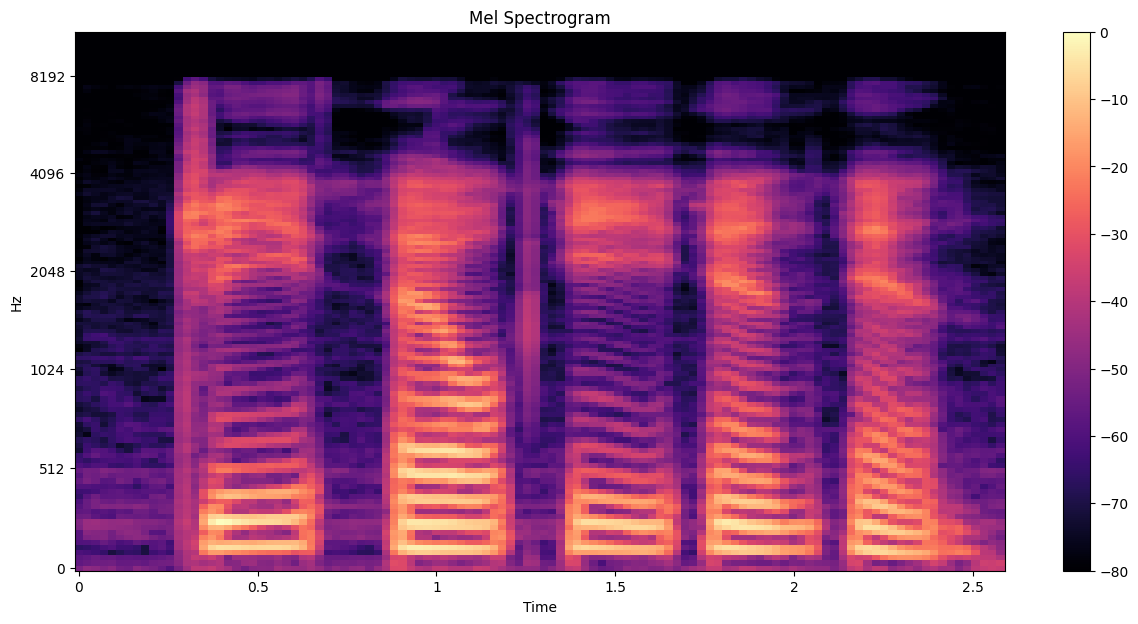

In [8]:
# Plot the mel spectrogram of our sample

mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel'
)
plt.colorbar()
plt.title("Mel Spectrogram")

## Convolutional ASR Models

### The Jasper Model

We will be training a small [Jasper (Just Another Speech Recognition) model](https://arxiv.org/abs/1904.03288) from scratch (e.g. initialized randomly). In brief, Jasper archs consist of repeated block structure that utilize 1D convolutions. In a Jasper_KxR model, `R` sub-blocks (consisting of a 1D convolution, batch norm, ReLU, and dropout) are grouped into a single block, which is then repeated `K` times. we also have one extra block at the beginning and a few more at the end that are invariant of `K` and `R`, and we use CTC loss.

### The QuartzNet Model

The QuartzNet is better variant of Jasper with a key difference that it uses time-channel separable 1D convolutions. This allows it to dramatically reduce number of weights while keeping similar accuracy

![QuartzNet with CTC](https://developer.nvidia.com/blog/wp-content/uploads/2020/05/quartznet-model-architecture-1-625x742.png)



## Using NeMo for ASR



In [4]:
import nemo
import nemo.collections.asr as nemo_asr

[NeMo W 2023-03-26 14:45:28 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2023-03-26 14:45:30 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.


## Using out of the box Model

NeMo's ASR collection comes with many building blocks and even complete models that we can use for training and evaluation. Moreover, several models come with pre-trained weights. Let's instantiate a complete QuartzNet-15x5 model

In [10]:
# will download pre-trained QuartzNet-15x5 model form NVIDIA NGC cloud and instantiate it
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2023-03-22 19:48:49 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /home/mat/.cache/torch/NeMo/NeMo_1.16.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2023-03-22 19:49:15 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-03-22 19:49:16 features:286] PADDING: 16
[NeMo I 2023-03-22 19:49:19 save_restore_connector:247] Model EncDecCTCModel was successfully restored from /home/mat/.cache/torch/NeMo/NeMo_1.16.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [11]:
files = [os.path.join(data_dir,  'an4/wav/an4_clstk/mgah/cen2-mgah-b.wav')]
for fname, transcription in zip(files, quartznet.transcribe(paths2audio_files=files)):
    print(f"Audio in {fname} was recognized as: {transcription}")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Audio in data/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav was recognized as: g l e n n


## Training from scratch

To train from scratch, you need to prepare your training data in the right format and specify your model architecture

### Creating Data Manifests 

The first thing we need to do now is to create manifests for our training and evaluation data, which will contain the metadata of audio files. NeMo data sets take in a standardized manifest format where each line corresponds to one sample of audio, such that the number of lines in a manifest is equal to the number of samples that are represented by that manifest. A line must contain the path to an audio file, the corresponding transcript (or path to a transcript file), and the duration of the audio sample.

Here's an example of what one line in a NeMo-compatible manifest might look like:
> {"audio_filepath": "path/to/audio.wav", "duration": 3.45, "text": "this is a nemo tutorial"}

We can build our training and evaluation manifests using `an4/etc/an4_train.transcription` and `an4/etc/an4_test.transcription`  which have lines containing transcripts and their corresponding audio file IDs:

```
...
<s> P I T T S B U R G H </s> (cen5-fash-b)
<s> TWO SIX EIGHT FOUR FOUR ONE EIGHT </s> (cen7-fash-b)
...

```



In [7]:
# Building our manifest file 
import json

# Function to build manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>','').replace('</s>','')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav'
                )

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')

# Building manifests
print("******")
train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_manifest = data_dir + '/an4/train_manifest.json'
if not os.path.isfile(train_manifest):
    build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')
    print('Training manifest created.')

test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_manifest = data_dir + '/an4/test_manifest.json'
if not os.path.isfile(test_manifest):
    build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')
    print("Test manifest created")
print("****Done****")

[NeMo W 2023-03-26 14:46:06 nemo_logging:349] <ipython-input-7-5f66104fb1f5>:22: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
    	This alias will be removed in version 1.0.
      duration = librosa.core.get_duration(filename=audio_path)
    


******
Test manifest created
****Done****


## Specifying our model with a YAML Config File

We'll build a *Jasper_4x1* model, with `K=4` blocks of single (`R=1`) sub-blocks and a greedy CTC decoder, unsing the configuration found in `./configs/config.yaml`

If we open up this config file, we find model section which describes architecture of our model. A model contains an entry labeled `encoder`, with a field called `jasper` that contains a list with multiple entries. Each of the members in the list specifies one block in our model, and looks something like this:

```yaml
-   filters: 128
    repeat: 1
    kernel: [11]
    stride: [2]
    dilation: [1]
    dropout: 0.2
    residual: false
    separable: true
    se: true
    se_context_size: -1
```

The first member of the list corresponds to the first block in the Jasper architecture diagram, which appears regardless of `K` and `R`. Next, we have 4 entries that correspond to the `K=4` blocks, and each has `repeat=1` since we are using `R=1`. These are followed by 2 more entries for the blocks that appear at the end of our Jasper model before the CTC loss.

There are also some entries at the top of the file that specify how we handle training (`train_ds`) and validation (`validation_ds`) data.

Using a YAML config such as this is helpful for getting a quick and human-readable overview of what your architecture looks like, and allows you to swap out model and run configurations easily without needing to change your code.

In [10]:
# Config Information

try:
    from ruamel.yaml import YAML
except ModuleNotFoundError: 
    from ruamel_yaml import YAML
config_path =  './configs/config.yaml'

if not os.path.exists(config_path):
    # Grab the config we'll use in this example
    BRANCH = 'r1.16.0'
    !mkdir configs
    !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'shuffle': False, 'num_work

## Training with PyTorch Lightning



In [11]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Next, we instantiate an ASR model based on our `config.yaml` file from the previous section. 

In [13]:
from omegaconf import DictConfig
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest
first_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

[NeMo I 2023-03-26 15:10:36 audio_to_text_dataset:45] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2023-03-26 15:10:36 audio_to_text_dataset:45] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2023-03-26 15:10:36 collections:193] Dataset loaded with 0 files totalling 0.00 hours
[NeMo I 2023-03-26 15:10:36 collections:194] 0 files were filtered totalling 0.00 hours


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
# Start training
trainer.fit(first_asr_model)